In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
# Read the CSV file, skipping problematic rows
data = pd.read_csv('WEC_Perth_49.csv', on_bad_lines='skip')

# Selecting top 1k rows
data = data.head(1000)
print(data.shape)

# Generate new column names
column_names = [f'X{i}' for i in range(1, 17)] + [f'Y{i}' for i in range(1, 17)] + [f'P{i}' for i in range(1, 17)] + ['Power_Output']

# Check if the number of columns matches the number of new column names
if len(data.columns) == len(column_names):
    # Assign the new column names to the DataFrame
    data.columns = column_names
    print("Column names have been updated successfully.")
else:
    print("Number of columns does not match the number of new column names.")


(1000, 149)
Number of columns does not match the number of new column names.


In [3]:
sample_data = data.sample(1000)
cat_columns = sample_data.select_dtypes(object).columns.to_list()
print(cat_columns)
print()
num_columns = sample_data.select_dtypes(np.number).columns.to_list()
print(num_columns)


[]

['X1', 'Y1', 'X2', 'Y2', 'X3', 'Y3', 'X4', 'Y4', 'X5', 'Y5', 'X6', 'Y6', 'X7', 'Y7', 'X8', 'Y8', 'X9', 'Y9', 'X10', 'Y10', 'X11', 'Y11', 'X12', 'Y12', 'X13', 'Y13', 'X14', 'Y14', 'X15', 'Y15', 'X16', 'Y16', 'X17', 'Y17', 'X18', 'Y18', 'X19', 'Y19', 'X20', 'Y20', 'X21', 'Y21', 'X22', 'Y22', 'X23', 'Y23', 'X24', 'Y24', 'X25', 'Y25', 'X26', 'Y26', 'X27', 'Y27', 'X28', 'Y28', 'X29', 'Y29', 'X30', 'Y30', 'X31', 'Y31', 'X32', 'Y32', 'X33', 'Y33', 'X34', 'Y34', 'X35', 'Y35', 'X36', 'Y36', 'X37', 'Y37', 'X38', 'Y38', 'X39', 'Y39', 'X40', 'Y40', 'X41', 'Y41', 'X42', 'Y42', 'X43', 'Y43', 'X44', 'Y44', 'X45', 'Y45', 'X46', 'Y46', 'X47', 'Y47', 'X48', 'Y48', 'X49', 'Y49', 'Power1', 'Power2', 'Power3', 'Power4', 'Power5', 'Power6', 'Power7', 'Power8', 'Power9', 'Power10', 'Power11', 'Power12', 'Power13', 'Power14', 'Power15', 'Power16', 'Power17', 'Power18', 'Power19', 'Power20', 'Power21', 'Power22', 'Power23', 'Power24', 'Power25', 'Power26', 'Power27', 'Power28', 'Power29', 'Power30', 'Power

In [4]:
s = MinMaxScaler()
data = pd.DataFrame(s.fit_transform(data), index= data.index, columns= data.columns)

X = data.iloc[:, :-1]  # Assuming the target variable is the last column
y = data.iloc[:, -1]   # Assuming the target variable is the last column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
}


In [12]:
# Define the hyperparameters grid for each model
param_grids = {
    "Linear Regression": {},
    "Decision Tree": {"max_depth": [None, 5, 10, 15]},
    "Random Forest": {"n_estimators": [100, 200, 300], "max_depth": [None, 5, 10, 15]},
}


In [13]:
# Perform GridSearchCV for each model
best_models = {}

for model_name, model in models.items():
    print("Tuning hyperparameters for", model_name)

    # Create GridSearchCV instance
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], scoring="neg_mean_squared_error", cv=5)

    # Fit the GridSearchCV
    grid_search.fit(X_train, y_train)

    # Get the best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Save the best model and its parameters
    best_models[model_name] = {"model": best_model, "params": best_params}

    # Print the best parameters and best score
    print("Best parameters:", best_params)
    print("Best score:", grid_search.best_score_)
    print()


Tuning hyperparameters for Linear Regression
Best parameters: {}
Best score: -1.2940552037110749e-15

Tuning hyperparameters for Decision Tree
Best parameters: {'max_depth': 5}
Best score: -0.0003582969196026342

Tuning hyperparameters for Random Forest
Best parameters: {'max_depth': None, 'n_estimators': 200}
Best score: -0.00022377446925193385



In [15]:
rmse_scores = {}

for model_name, model_data in best_models.items():
    model = model_data["model"]
    params = model_data["params"]

    print("Evaluating", model_name)
    print("Best parameters:", params)

    # Fit the model with best parameters
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model's performance
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores[model_name] = rmse

    print("Root Mean Squared Error:", rmse)
    print()


Evaluating Linear Regression
Best parameters: {}
Root Mean Squared Error: 2.9611365814918663e-08

Evaluating Decision Tree
Best parameters: {'max_depth': 5}
Root Mean Squared Error: 0.019872180979784954

Evaluating Random Forest
Best parameters: {'max_depth': None, 'n_estimators': 200}
Root Mean Squared Error: 0.014295731704812192



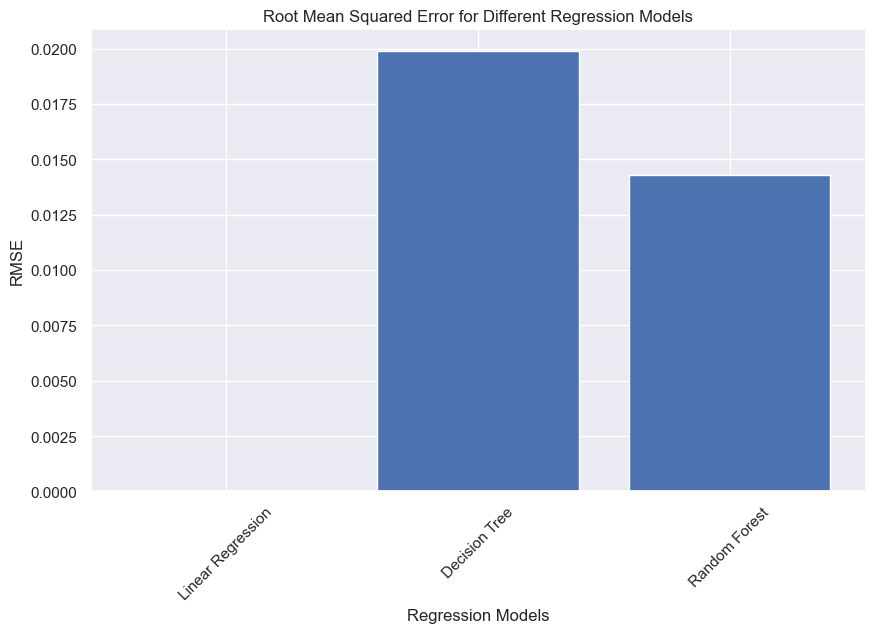

In [16]:
plt.figure(figsize=(10, 6))
plt.bar(rmse_scores.keys(), rmse_scores.values())
plt.xlabel("Regression Models")
plt.ylabel("RMSE")
plt.title("Root Mean Squared Error for Different Regression Models")
plt.xticks(rotation=45)
plt.show()
